# Experiment 4: All available people at all available aspect angles compared with all available data apart from subject A

*   Two tests
*   First uses all available people at all available aspect angles
*   Second uses all available data except from subject A





## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
else:
    BASE_PATH = "C:/Users/macka/Google Drive/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/'
MODEL_PATH = BASE_PATH + 'models/original_experiments/experiment_4/'
FIGURE_PATH = BASE_PATH + 'reports/figures/original_experiments/experiment_4/'
REPORT_PATH = BASE_PATH + 'reports/original_experiments/experiment_4/'
    
from src.models.original_models import cnn_64_128
from src.data import load_data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Found existing installation: src 0.1.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from six.moves import cPickle
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping 
import sys
from sklearn.metrics import classification_report,confusion_matrix
import csv
from keras.models import load_model

In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

In [0]:
data_folders = {
    'mixed':{"nb_train_samples": 52695},
    'mixed_angle_A':{"nb_train_samples":43450}}

In [0]:
load_models = False

batch_size = 100
nb_classes = 7
nb_epoch = 120
nb_epoch = 2

# input image dimensions
img_rows, img_cols = 75, 75
# the CIFAR10 images are RGB

target_names = ['ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm', 'Clapping', 'PickingUp', 'Sitting', 'Walking']

## Training and Evaluating Models

In [7]:
for name, data_folder in data_folders.items():
    # the data, shuffled and split between train and test sets
    (X_train, y_train), (X_test, y_test) = load_data.load_data((DATA_PATH + name), data_folder["nb_train_samples"])

    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    
    if not load_models:
        model = cnn_64_128.make_model(img_rows, img_cols, nb_classes)
    
        # let's train the model using SGD + momentum (how original).
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        X_train /= 255
        X_test /= 255
        history = model.fit(
            X_train,
            Y_train,
            batch_size=batch_size,
            epochs=nb_epoch,
            validation_data=(X_test, Y_test),
            shuffle=True,
            verbose=1)
        data_folder["history"] = history
        
    else:
        model = load_model(MODEL_PATH + name + '.h5')


    y_pred = model.predict_classes(X_test)
    data_folder["model"] = model 
    data_folder["classification_report"] = classification_report(
            np.argmax(Y_test,axis=1),
            y_pred,
            target_names=target_names)
    data_folder["confusion_matrix"] = confusion_matrix(
            np.argmax(Y_test,axis=1), y_pred)

Train on 52695 samples, validate on 10539 samples
Epoch 1/2
52695/52695 [==============================] - 113s 2ms/step - loss: 0.5208 - acc: 0.7972 - val_loss: 0.1629 - val_acc: 0.9464
Epoch 2/2
52695/52695 [==============================] - 108s 2ms/step - loss: 0.1233 - acc: 0.9589 - val_loss: 0.0689 - val_acc: 0.9789
Train on 43450 samples, validate on 8690 samples
Epoch 1/2
43450/43450 [==============================] - 90s 2ms/step - loss: 0.6056 - acc: 0.7644 - val_loss: 0.9012 - val_acc: 0.7471
Epoch 2/2
43450/43450 [==============================] - 88s 2ms/step - loss: 0.1184 - acc: 0.9590 - val_loss: 1.2846 - val_acc: 0.7397


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Analysis and Saving of Results

In [0]:
save_graph = True
save_model = True
save_report = True

### Plot and Save graph

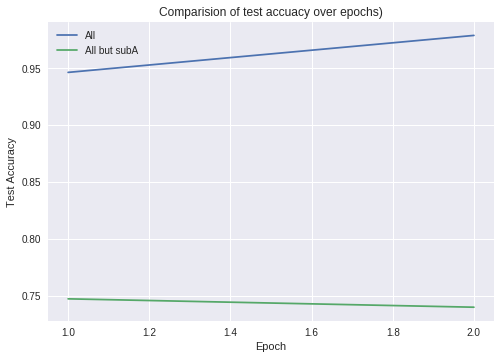

In [10]:
import matplotlib.pyplot as plt
for name, data_folder in data_folders.items():
    if name == "mixed":
        name = "All"
    elif name == "mixed_angle_A":
        name = "All but subA"
        
    val_acc = data_folder["history"].history['val_acc']
    epochs = range(1, len(val_acc)+1)
    plt.plot(epochs, val_acc, label=name)
    
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Comparision of test accuacy over epochs)')
if save_graph:
    plt.savefig(FIGURE_PATH + "test_accuracy_comparison.svg", format='svg', dpi=1200)
plt.show()

### Save Models

In [0]:
if not load_models and save_model:
    for name, data_folder in data_folders.items():
        data_folder['model'].save(MODEL_PATH + name + '.h5')

### Save Classification Report and Confusion Matricies

In [0]:
if save_report:
    file = open(REPORT_PATH + 'Classification_and_Confusion.txt', 'w') 

    for name, data_folder in data_folders.items():
        file.write("--------------------------------------------------\n") 
        file.write("Data Name: " + name + "\n") 
        file.write("Classification Report:\n") 
        file.write(data_folder['classification_report'])
        file.write("Confusion Matrix:\n") 
        file.write(np.array2string(data_folder['confusion_matrix']) + "\n")

    file.close() 